# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [25]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [26]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [27]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
sfo_data.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
year,,,,
2010,Alamo Square,291.182945,372560,1239
2010,Anza Vista,267.932583,372560,1239
2010,Bayview,170.098665,372560,1239
2010,Buena Vista Park,347.394919,372560,1239
2010,Central Richmond,319.027623,372560,1239


In [28]:
file_path1 = Path("Data/neighborhoods_coordinates.csv")
neigh_data= pd.read_csv(file_path1)
neigh_data.head()

,Neighborhood,Lat,Lon
0,Alamo Square,37.791012,-122.402100
1,Anza Vista,37.779598,-122.443451
2,Bayview,37.734670,-122.401060
3,Bayview Heights,37.728740,-122.410980
4,Bernal Heights,37.728630,-122.443050


In [35]:
neighborhood_mean = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot', 'housing_units', 'gross_rent'].mean().reset_index()
neighborhood_mean.head()
neigh_year =  sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
neigh_year.reset_index(inplace=True)
combined_df = pd.concat([neighborhood_mean, neigh_data], axis='columns', join='inner').dropna()
combined_df.drop(columns=['Neighborhood'], inplace=True)
combined_df.head()

C:\Users\aelri\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,neighborhood,sale_price_sqr_foot,housing_units,gross_rent,Lat,Lon
0,Alamo Square,366.020712,378401.0,2817.285714,37.791012,-122.402100
1,Anza Vista,373.382198,379050.0,3031.833333,37.779598,-122.443451
2,Bayview,204.588623,376454.0,2318.400000,37.734670,-122.401060
3,Bayview Heights,590.792839,382295.0,3739.000000,37.728740,-122.410980
4,Bernal Heights,576.746488,379374.5,3080.333333,37.728630,-122.443050


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [44]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    number_of_units = sfo_data.groupby("year").mean()["housing_units"]
    min_hsg=min(number_of_units)
    max_hsg=max(number_of_units)
    std_hsg=number_of_units.std()
    bar_plot = number_of_units.plot.bar(title="Average housing units per year")
    row = pn.Row(bar_plot)
    bar_plot.set_ylim(min_hsg-std_hsg,max_hsg+std_hsg)
    return bar_plot
    


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    avg_sale = sfo_data.groupby("year")[["sale_price_sqr_foot","gross_rent"]].mean()
    avg_rent_plot= avg_sale['gross_rent'].plot(kind="line",title="Average monthly rent")
    return avg_rent_plot



def average_sales_price():
    avg_sale = sfo_data.groupby("year")[["sale_price_sqr_foot","gross_rent"]].mean()
    avg_sq_plot= avg_sale['sale_price_sqr_foot'].plot(kind="line",title="Average sale price per sq ft")
    return avg_sq_plot    
   

def average_price_by_neighborhood():
    neigh_year =  sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    neigh_year.reset_index(inplace=True)
    return neigh_year.hvplot(x="year", y="sale_price_sqr_foot",title="average price per sq ft",groupby="neighborhood")



def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    avg_values = neigh_year.drop(columns=['year']).groupby('neighborhood').mean().round(2)
    expensive_neighborhood = avg_values.sort_values("sale_price_sqr_foot", ascending = False).head(10)
    return expensive_neighborhood['sale_price_sqr_foot'].hvplot.bar(label='Top 10 - Expensive Neighborhoods ', xlabel='Neighborhood', 
    ylabel='Avg. Sales Price per Square Foot',  height=400,rot=90)
    


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    neigh_year.head(10)
    return neigh_year.hvplot.bar(x='year', y=['sale_price_sqr_foot', 'gross_rent'], xlabel='Year', ylabel='Avg price, Gross rent', 
    groupby='neighborhood', rot=90, width=700, height=500)
   

def neighborhood_map():
    load_dotenv()
    map_box_api = os.getenv("mapbox")
    px.set_mapbox_access_token("mapbox")
# Create a scatter mapbox to analyze neighborhood info
    map_plot = px.scatter_mapbox(
    combined_df,
    lat="Lat",
    lon="Lon",
    size="gross_rent",
    color="neighborhood",zoom=4
    )
    return map_plot.show()

    # YOUR CODE HERE!



## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

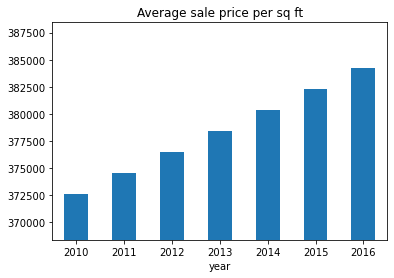

In [47]:
# Create a Title for the Dashboard
rental_market_analysis=pn.Column("## Neighbourhood",neighborhood_map())
housing_units_analysis = pn.Column("## Cost analysis", housing_units_per_year())
avg_cost_analysis=pn.Column("## Average Prices", average_gross_rent(), average_sales_price(),average_price_by_neighborhood())
expensive_neigh = pn.Column("## Expensive neighbourhood", top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())

# Create a tab layout for the dashboard

dashboard = pn.Tabs(
    (
        "Neighbourhood",
        rental_market_analysis
    ),
    (
        "Housing Units Analysis",
        housing_units_analysis 
    ),
    (
        "Average Cost Analysis",
       avg_cost_analysis
    ),
    (
        "Expensive Neighbourhood Analysis",
        expensive_neigh
    )
    
)

## Serve the Panel Dashboard

In [48]:
# Serve the# dashboard
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'28a495c1-2bfa-41d8-be1c-beddc1f9557d': {'defs': …

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Str(None)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Str(AxesSubplot)
    [2] Column
        [0] Markdown(str)
        [1] Str(AxesSubplot)
        [2] Str(AxesSubplot)
        [3] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [3] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
        [2] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

BokehModel(combine_events=True, render_bundle={'docs_json': {'c3c2a70f-734a-4810-8878-43bd5816a201': {'defs': …

Row
    [0] Str(AxesSubplot)

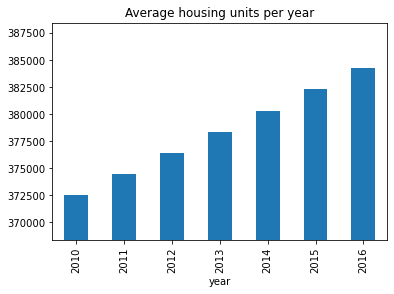

In [50]:
housing_units_per_year()

<AxesSubplot:title={'center':'Average monthly rent'}, xlabel='year'>

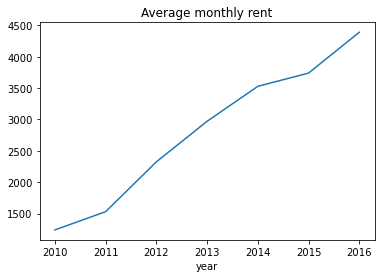

In [51]:
 average_gross_rent()

<AxesSubplot:title={'center':'Average sale price per sq ft'}, xlabel='year'>

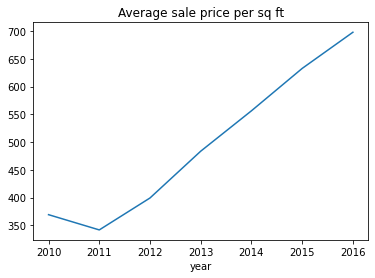

In [52]:
average_sales_price()

In [53]:
average_price_by_neighborhood()

BokehModel(combine_events=True, render_bundle={'docs_json': {'2230e74f-c26c-4def-ad45-571b2c3277b2': {'defs': …

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [54]:
 top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [55]:
most_expensive_neighborhoods_rent_sales()

BokehModel(combine_events=True, render_bundle={'docs_json': {'f9abeba6-13e9-4a1d-90ae-9b520628a6ea': {'defs': …

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [60]:
neighborhood_map()